<a href="https://colab.research.google.com/github/mailazorzan/mnist/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST

## Importação das bibliotecas

In [1]:
import os
import struct
import numpy as np
import gzip
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import itertools
import matplotlib.pyplot as plt

## Leitura dos dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_mnist(path, kind = 'train'):
  """Load MNIST data from 'path' """
  labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
  images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)
    
  with gzip.open(labels_path, 'rb') as lbpath:
    lbpath.read(8)
    buffer = lbpath.read()
    labels = np.frombuffer(buffer, dtype = np.uint8)
        
  with gzip.open(images_path, 'rb') as imgpath:
    imgpath.read(16)
    buffer = imgpath.read()
    images = np.frombuffer(buffer, dtype = np.uint8).reshape(len(labels), 784).astype(np.float64)
        
  return images, labels

train_images, train_labels = load_mnist("/content/drive/MyDrive/Portfolio/Diversos/MNIST/", kind = 'train')
test_images, test_labels = load_mnist("/content/drive/MyDrive/Portfolio/Diversos/MNIST/", kind = 't10k')

In [4]:
train_images.shape
train_labels.shape
test_images.shape
test_labels.shape

(10000,)

### Matriz de Confusão

In [5]:
print(__doc__)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def printConfusion(test_labels, predicted):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_labels, predicted)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Matriz de Confusão')

    plt.show()

Automatically created module for IPython interactive environment


### Mostrar Números

##### Testando e validando os números da base

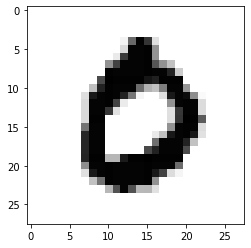

In [6]:
#Mostrar números
import matplotlib.pyplot as pt


w = test_images[3]
w = w.reshape(28,28)

pt.imshow(255-w,cmap='gray')
pt.show()

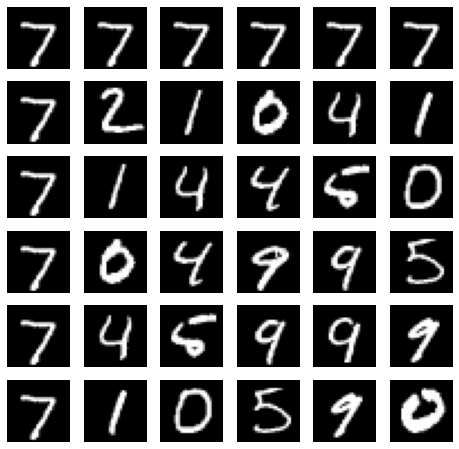

In [7]:
plt.figure(figsize=(8,8))
for i in range(6):
    for j in range(6):
        plt.subplot(6,6,i+6*j+1)
        w = test_images[i*j]
        pt.imshow(w.reshape(28,28),cmap='gray')
        plt.axis('off')
plt.show()

Abaixo, aplicaremos o PCA e o LDA, e em seguida, implementaremos os modelos de classificação em três versões: com a base original, com PCA e com LDA.

### PCA

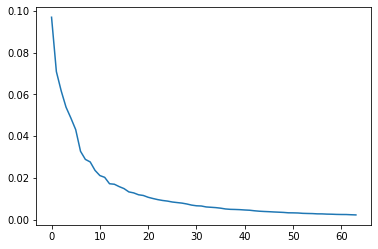

In [10]:
pca = PCA(n_components=64, whiten=False)
data = pca.fit_transform(train_images)
plt.plot(pca.explained_variance_ratio_)
plt.show()

Aplicamos o PCA com um número de componentes escolhido aleatoriamente (__64__), no gráfico podemos observar a porcentagem da variância explicada por cada componente. Aproximadamente após o décimo segundo componente, fica evidente que, o ganho começa a se tornar insignificativo para cada componente adicionado. Logo, decidimos por utilizar esse valor para o número de componentes aplicados no PCA.

In [11]:
pca = PCA(n_components=12, whiten=False)
train_images_pca = pca.fit_transform(train_images)
test_images_pca = pca.transform(test_images)
test_images_pca.shape

(10000, 12)

Com o código abaixo podemos plotar alguns elementos da base __antes__ e __depois__ da transformação com o PCA. Sabemos que com a aplicação do PCA existe perda de informação. Então, a base de dimensões 784 foi reduzida para apenas 12. Realizamos a transformação inversa, tentando recriar as 784 dimensões a partir das 12 ainda existentes para plotar o gráfico. Como resultado, podemos ver os dígitos mais embaçados e com menos qualidade do que os originais, devido a perda de informação.

Números antes da aplicação do PCA: 


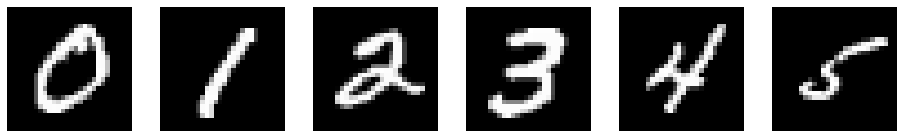

Números após a aplicação do PCA: 


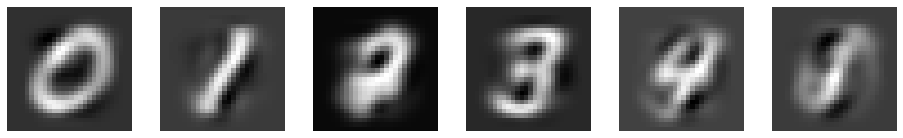

In [13]:
train_back  = pca.inverse_transform(train_images_pca)

plt.figure(figsize=(16,16))

print("Antes da aplicação do PCA: ")
for i in range(6):
    plt.subplot(6,6,i+6*1+1)
    w = train_images[i*2+1]
    plt.imshow(w.reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(16,16))

print("Após a aplicação do PCA: ")
for i in range(6):
    plt.subplot(6,6,i+6*2+1)
    w = train_back[i*2+1]
    plt.imshow(w.reshape(28,28),cmap='gray')
    plt.axis('off')

plt.show()

### LDA

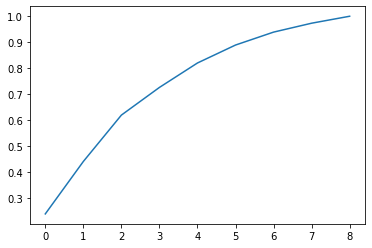

In [14]:
import warnings
warnings.simplefilter('ignore')

lda = LDA(n_components=None)
train_images_lda_teste = lda.fit(train_images,train_labels)
plt.plot(np.cumsum(lda.explained_variance_ratio_))
plt.show()

Para definir a quantidade de componentes para o LDA, faremos uma análise parecida com a do PCA. O gráfico acima mostra a soma acumulada da variância explicada por cada componente. Para avaliação do modelo, escolhemos o valor __7__ por conseguir explicar mais de 90% da variância.

In [15]:
lda = LDA(n_components=7)

train_images_lda = lda.fit_transform(train_images,train_labels)
test_images_lda = lda.fit_transform(test_images,test_labels)

# KNN

In [16]:
#Importa a biblioteca
from sklearn.neighbors import KNeighborsClassifier
#Assume que você tem X (previsor) e Y (alvo) para dados de treino e x_test(previsor) dos dados de teste
#Cria modelo de objeto de classificação KNeighbors 
def execKNN(train_images1, train_labels1, test_images1, vizinhos = 5):
    modelKNN = KNeighborsClassifier(n_neighbors=vizinhos) # default value for n_neighbors is 5
    #Treina o modelo usando os dados de treine e confere o score
    modelKNN.fit(train_images1, train_labels1)
    #Prevê o resultado
    predictedKNN = modelKNN.predict(test_images1)
    return predictedKNN

### Base Original

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.95      1.00      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Acurácia: :  0.9688
R^2:  0.9251061075916786
Tempo de execução:  1012.9923360347748 s

Matriz: 


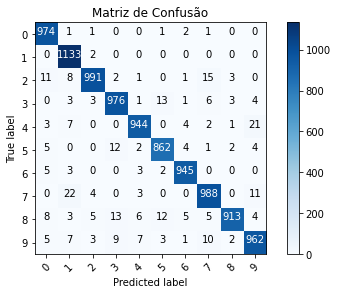

In [17]:
from sklearn.metrics import accuracy_score, r2_score, classification_report
import time

knn_t_start = time.time()
predictedKNN = execKNN(train_images, train_labels, test_images)
knn_t_end = time.time()
knn_t = (knn_t_end - knn_t_start)
print(classification_report(test_labels, predictedKNN))
print("Acurácia: : ", accuracy_score(test_labels, predictedKNN))
print("R^2: ", r2_score(test_labels, predictedKNN))
print("Tempo de execução: ", knn_t, "s")
print("\nMatriz: ")
printConfusion(test_labels,predictedKNN)

### Base pós PCA

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.95      0.92      0.93      1010
           4       0.93      0.93      0.93       982
           5       0.92      0.93      0.93       892
           6       0.96      0.97      0.97       958
           7       0.95      0.94      0.95      1028
           8       0.92      0.90      0.91       974
           9       0.90      0.91      0.90      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Acurácia: :  0.944
R^2:  0.8825072248396842
Tempo de execução:  3.6754724979400635 s

Matriz: 


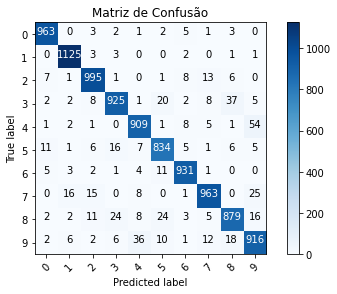

In [18]:
from sklearn.metrics import accuracy_score, r2_score, classification_report
import time

knn_pca_t_start = time.time()
predictedKNN = execKNN(train_images_pca, train_labels, test_images_pca)
knn_pca_t_end = time.time()
knn_pca_t = (knn_pca_t_end - knn_pca_t_start)
print(classification_report(test_labels, predictedKNN))
print("Acurácia: : ", accuracy_score(test_labels, predictedKNN))
print("R^2: ", r2_score(test_labels, predictedKNN))
print("Tempo de execução: ", knn_pca_t, "s")
print("\nMatriz: ")
printConfusion(test_labels,predictedKNN)

### Base pós LDA

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       980
           1       0.92      0.80      0.86      1135
           2       0.90      0.90      0.90      1032
           3       0.88      0.89      0.88      1010
           4       0.84      0.86      0.85       982
           5       0.77      0.75      0.76       892
           6       0.94      0.94      0.94       958
           7       0.63      0.93      0.75      1028
           8       0.81      0.81      0.81       974
           9       0.79      0.52      0.62      1009

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

Acurácia: :  0.8332
R^2:  0.6681532722684789
Tempo de execução:  1.3317575454711914 s

Matriz: 


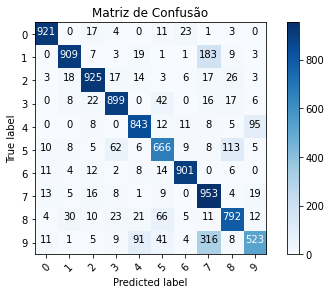

In [19]:
from sklearn.metrics import accuracy_score, r2_score, classification_report
import time

knn_lda_t_start = time.time()
predictedKNN = execKNN(train_images_lda, train_labels, test_images_lda)
knn_lda_t_end = time.time()
knn_lda_t = (knn_lda_t_end - knn_lda_t_start)
print(classification_report(test_labels, predictedKNN))
print("Acurácia: : ", accuracy_score(test_labels, predictedKNN))
print("R^2: ", r2_score(test_labels, predictedKNN))
print("Tempo de execução: ", knn_lda_t, "s")
print("\nMatriz: ")
printConfusion(test_labels,predictedKNN)

### Análise KNN

O KNN apresentou uma acurácia de quase 97% e um R^2 de aproximadamente 92.5% com a base original. Mesmo após o uso do PCA, o algoritmo conseguiu performar muito bem, perdendo apenas, aproximadamente, 3 pontos percentuais nas métricas calculadas, visto que o KNN se mostra um algoritmo mais custoso computacionalmente, seu tempo de processamento é muito menor com a redução dos componentes da base (cerca de 99.5% mais rápido).

O LDA, por outro lado, mostra resultados bem inferiores com apenas 83% de acurácia.